<a href="https://colab.research.google.com/github/JLee823/2023-1st-AI-assisted-drug-discovery-SNU/blob/main/Week6_1_Methods_for_avoiding_overfitting_Regularization_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods for regularization
----------
딥러닝 기반의 예측 모델을 생성할 때, 과적합(overfitting)이 일반적으로 문제가 될 확률이 높습니다. 

왜냐하면 일반적인 딥러닝에서는 굉장히 많은 숫자의 파라미터를 사용하게 되는데, 데이터의 개수보다 파라미터의 개수가 많다면 단순 데이터 기억(memorization)을 수행하게 될 가능성이 생기게 됩니다. 

최근, 실제 잘 훈련된 딥러닝 모델에서는 overfitting 문제를 피하면서 좋은 결과를 주는 경우들을 많이 볼 수 있습니다. 

어떻게 최근의 딥러닝 모델들이 효과적으로 overfitting을 피하는지 또는 overfitting을 어느 정도 감수하면서도 좋은 예측 결과를 얻을 수 있는지는 여전히 활발히 연구의 대상이 되고 있습니다. 


일단 이번 수업에서는 효과적으로 딥러닝에서 과적합을 피하면서 효과적으로 학습시킬 수 있는 몇가지 방법을 알아보도록 하겠습니다. 

In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


필요한 모듈을 불러옵니다. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
torch.manual_seed(456)

## 데이터셋
--------

이번 수업에서도 지난 번에 사용했던 tox21 데이터를 사용하도록 하겠습니다. 

https://tripod.nih.gov/tox21/challenge/


지난 시간에 만들었던 Dataset class를 이용하도록 할 예정입니다. 

일단, 기본값은 SMILES를 1024 bit의 ECFP4로 변환시켜서 사용하도록 하겠습니다. 

In [ ]:
import torch.utils.data as data

class Tox21Dataset(data.Dataset):
    
    def __init__(self, radius=2, nbits=1024): # default radius & nbits are 2 and 1024, respectively.
        """
        Inputs:
            raw_df: 초기 tox21 데이터
            df_sub: "NR-AR"과 "smiles" 열 만으로 구성된 DataFrame
        """
        super().__init__()
        # Read initial data
        self.raw_df=pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz')
        
        # NR-AR과 smiles 열만 추출
        self.df_sub=self.raw_df[["NR-AR", "smiles"]].copy() 
        
        # NR-AR column에 NaN이 있는 raw를 제거하고 index를 reset.
        self.df_sub=self.df_sub.dropna(axis='index', subset='NR-AR').reset_index(drop=True) 
        
        # Convert SMILES into fingerprints
        fp_list = []
        for smi in tqdm(self.df_sub["smiles"]):
          m = Chem.MolFromSmiles(smi)
          fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)
          fp_list.append(fp.ToList())
        
        # Convert fingerprints into torch.float variables
        self.data=torch.tensor(fp_list, dtype=torch.float32)  #input data to tensor
        print("self.data:")
        print(self.data)

        print("self.data.shape:")
        print(self.data.shape)

        # Convert labels (0 and 1) to torch.float variables
        self.label=torch.tensor(self.df_sub["NR-AR"].values, dtype=torch.float32)  # target_label to tensor
        
        print("self.label:")
        print(self.label)
        print(self.label.shape)

        # Print out the final message. 
        print("Tox21 data preparation is finished!")

    def __len__(self):
        # 전체 데이터의 개수를 return하는 함수
        return len(self.data)

    def __getitem__(self, idx):
        # idx 번째 데이터와 레이블을 리턴하는 함수
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

위의 Tox21Dataset 클래스를 이용하여 tox21 데이터셋을 읽어들인다. 

In [ ]:
tox21_dataset = Tox21Dataset()

100%|██████████| 7265/7265 [00:01<00:00, 5146.16it/s]


self.data:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
self.data.shape:
torch.Size([7265, 1024])
self.label:
tensor([0., 0., 0.,  ..., 1., 1., 0.])
torch.Size([7265])
Tox21 data preparation is finished!


In [ ]:
# 데이터셋 사이즈 얻기
dataset_size = len(tox21_dataset)
# 80%를 학습데이터
train_size = int(dataset_size * 0.8)
# 10%는 검증데이터
validation_size = int(dataset_size * 0.1)
# 나머지를 테스트 데이터로 사용함. 
test_size = dataset_size - train_size - validation_size

# 전체 데이터셋을 무작위로 세가지의 셋으로 나눔. 
train_dataset, validation_dataset, test_dataset = data.random_split(tox21_dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 5812
Validation Data Size : 726
Testing Data Size : 727


In [ ]:
train_dataset[0]

(tensor([0., 1., 0.,  ..., 0., 1., 0.]), tensor(0.))

입력 값과 출력 값이 잘 변환된 것을 확인할 수 있다. 

배치 학습을 위해서 DataLoader 클래스를 이용한다. 

In [ ]:
bs_size = 128
train_loader = data.DataLoader(train_dataset, batch_size=bs_size, shuffle=True)
val_loader = data.DataLoader(validation_dataset, batch_size=bs_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=bs_size, shuffle=True)

## 다양한 모델 정규화 방법들(model regularization)
--------

GPU가 사용가능하면 GPU를 사용하도록 한다. 

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


### 배치 정규화(batch regularization)
------

배치 학습을 수행할 때, 각 batch들의 평균 값과 표준 편차 값이 모두 다릅니다. 

경험적으로 볼 때, 이러한 평균과 표준편차 값을 조정하여 각 batch의 데이터들이 비슷한 분포를 가지도록 하는 것을 배치 정규화라고 합니다. 

배치 정규화는 다음의 식으로 정의됩니다. 

\begin{equation}
f(X) = \gamma\frac{X - \bar{X}(B)}{S(B)} + \beta
\end{equation}

위 식에서 $\bar{X}({B})$는 배치 (B)의 평균 텐서이고, $S(B)$는 배치의 표준편차를 의미합니다. 

$\gamma$와 $\beta$의 기본값은 각 1과 0입니다. 

그리고 최적의 $\gamma$와 $\beta$는 학습 과정에서 학습이 되어서 조정됩니다. 

위 식을 이용하면 각 batch의 데이터가 0 근방에서 표준편차 1을 가지면서 분포하는 분포를 가지게 됩니다. 


pytorch에는 아래와 같은 세가지의 Batch Normalization 연산 layer들이 구현되어 있습니다: 

[torch.nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d), [torch.nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#batchnorm2d), and [torch.nn.BatchNorm3d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html#batchnorm3d). 


### 드랍 아웃 (Dropout)

----

드랍 아웃은 학습시 일부 connection을 확률적으로 고려하지 않음으로써 과적합을 막는 방법입니다. 

실제로는 dropout layer는 일부 output을 확률적으로 0에 만드는 역학을 하게 됩니다. 

다른 표현으로는 "masking"이라고도 할 수 있습니다. 

이러한 dropout은 개념적으로는 매번 connection이 확률적으로 다른 feature를 학습하도록 하는 것과 유사하다고 볼 수 있습니다. 

드랍아웃의 이론적인 근거는 약하지만 경험적으로 많은 경우에 잘 작동하기 때문에 매우 널리 사용되고 있는 layer입니다 (Gal and Ghahramani 2016)[https://proceedings.mlr.press/v48/gal16.html]. 

pyTorch에서는 [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) 이라는 layer로 구현되어 있습니다. 

<img src="https://dmol.pub/_images/drop_out.gif" width=500>


위의 두 가지의 layer를 [지난 시간에 만들었던 모델](https://colab.research.google.com/github/JLee823/2023-1st-AI-assisted-drug-discovery-SNU/blob/main/Week4_introduction_to_PyTorch_Tensor_Multilayer_percetron.ipynb#scrollTo=dltlGlY5bIk9&line=11&uniqifier=1)에 적용하여 보자. 

In [ ]:
class Binary_Classifier_v1(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, drop_out_rate=0.1):
        super().__init__()
        # 네트워크를 구성하는 위한 기반이 되는 layer들을 정의한다. 
        # 차원의 변화: num_inputs  -> num_hidden
        self.linear1 = nn.Linear(num_inputs, num_hidden) 
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        self.linear3 = nn.Linear(num_hidden, num_outputs)
        
        # activation function
        self.act_fn = nn.Tanh()

        # dropout layer: 30%의 node의 output을 사용하지 않음. 
        self.dropout = nn.Dropout(drop_out_rate)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.act_fn(x)

        x = self.linear2(x)
        x = self.dropout(x)
        x = self.bn2(x)
        x = self.act_fn(x)

        x = self.linear3(x)

        return x

위의 class를 기반으로 dropout rate이 10%인 model을 하나 생성해보자. 

In [ ]:
model = Binary_Classifier_v1(1024, 512, 1, drop_out_rate=0.1)
model.to(device) # Use GPU for our model

Binary_Classifier_v1(
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=512, out_features=1, bias=True)
  (act_fn): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

지난 시간과 동일한 학습을 수행하는 함수를 다음과 같이 정의한다. 

In [ ]:
def train_model(model, optimizer, train_loader, validation_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train() 
    train_loss_list = []
    validation_loss_list = []

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        for data_inputs, data_labels in train_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            train_loss += loss.item() # sum over batches

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

        # save a training loss at a given epoch
        train_loss_list.append(train_loss)
        ### END of the TRAINING step.

        #### START of validation loss calculation.
        # evaluation using the VALIDATION set
        model.eval()
        val_loss = 0.0
        for data_inputs, data_labels in validation_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            val_loss += loss.item() # sum over batches

        validation_loss_list.append(val_loss)
        #Print information out
        if epoch % 5 == 0:
          print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
          
        model.train()
    return train_loss_list, validation_loss_list

Adam Optimizer를 사용한다. 

In [ ]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Binary Classification 모델이므로 Binary Cross Entropy 함수를 손실함수로 사용한다. 

In [ ]:
loss_module = nn.BCEWithLogitsLoss()

In [ ]:
train_loss, validation_loss = train_model(model, optimizer, train_loader, val_loader, loss_module)

  2%|▏         | 2/100 [00:00<00:16,  5.95it/s]

Epoch: 000, Training Loss: 19.9636, Validation Loss: 1.3774


  7%|▋         | 7/100 [00:01<00:15,  6.00it/s]

Epoch: 005, Training Loss: 1.7778, Validation Loss: 0.9898


 12%|█▏        | 12/100 [00:01<00:14,  6.10it/s]

Epoch: 010, Training Loss: 0.6481, Validation Loss: 1.1226


 17%|█▋        | 17/100 [00:02<00:13,  6.08it/s]

Epoch: 015, Training Loss: 0.4420, Validation Loss: 1.3481


 22%|██▏       | 22/100 [00:03<00:13,  6.00it/s]

Epoch: 020, Training Loss: 0.3126, Validation Loss: 1.3209


 27%|██▋       | 27/100 [00:04<00:12,  6.05it/s]

Epoch: 025, Training Loss: 0.3393, Validation Loss: 1.4483


 32%|███▏      | 32/100 [00:05<00:11,  6.03it/s]

Epoch: 030, Training Loss: 0.2196, Validation Loss: 1.5396


 37%|███▋      | 37/100 [00:06<00:10,  6.02it/s]

Epoch: 035, Training Loss: 0.6700, Validation Loss: 2.1146


 42%|████▏     | 42/100 [00:06<00:09,  6.15it/s]

Epoch: 040, Training Loss: 0.4253, Validation Loss: 1.5371


 47%|████▋     | 47/100 [00:07<00:08,  6.10it/s]

Epoch: 045, Training Loss: 0.2432, Validation Loss: 1.5561


 52%|█████▏    | 52/100 [00:08<00:07,  6.13it/s]

Epoch: 050, Training Loss: 0.1842, Validation Loss: 1.6110


 57%|█████▋    | 57/100 [00:09<00:07,  5.98it/s]

Epoch: 055, Training Loss: 0.1793, Validation Loss: 1.6216


 62%|██████▏   | 62/100 [00:10<00:06,  6.17it/s]

Epoch: 060, Training Loss: 0.1330, Validation Loss: 1.5555


 67%|██████▋   | 67/100 [00:11<00:05,  6.09it/s]

Epoch: 065, Training Loss: 0.1903, Validation Loss: 1.5200


 72%|███████▏  | 72/100 [00:11<00:04,  6.16it/s]

Epoch: 070, Training Loss: 0.1907, Validation Loss: 1.8051


 77%|███████▋  | 77/100 [00:12<00:03,  6.17it/s]

Epoch: 075, Training Loss: 0.1610, Validation Loss: 1.6175


 82%|████████▏ | 82/100 [00:13<00:02,  6.16it/s]

Epoch: 080, Training Loss: 0.1441, Validation Loss: 1.7399


 87%|████████▋ | 87/100 [00:14<00:02,  5.87it/s]

Epoch: 085, Training Loss: 0.1411, Validation Loss: 1.7400


 92%|█████████▏| 92/100 [00:15<00:01,  5.84it/s]

Epoch: 090, Training Loss: 0.2727, Validation Loss: 2.3625


 97%|█████████▋| 97/100 [00:16<00:00,  5.61it/s]

Epoch: 095, Training Loss: 0.3985, Validation Loss: 1.5018


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Training loss와 Validation loss를 표현하는 그래프를 그려주는 함수를 다음과 같이 정의하자.

In [ ]:
def draw_loss_changes(train_loss, validation_loss):
  plt.plot(train_loss, '.', color='b', label='train')
  plt.plot(validation_loss, '.', color='orange', label='validation')
  plt.xlabel("Epoch", fontsize='xx-large')
  plt.ylabel("Loss", fontsize='xx-large')
  plt.ylim(ymin=0, ymax=5.0)
  plt.legend(fontsize='xx-large')

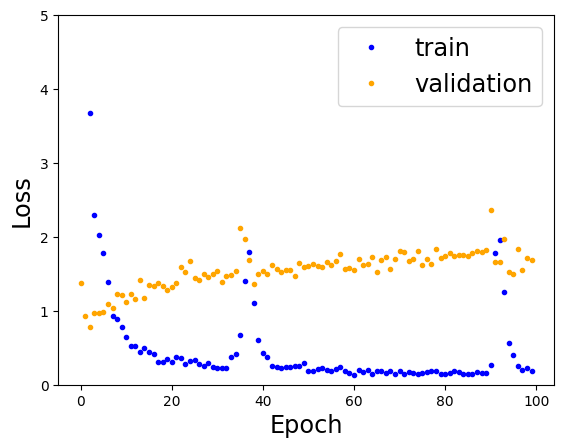

In [ ]:
draw_loss_changes(train_loss, validation_loss)

Test set에 대해서 실제 성능을 evaluation하는 함수를 아래와 같이 정의하고 성능을 체크해보자. 

In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
eval_model(model, test_loader)

Accuracy of the model: 96.01%


#### 이번에는 dropout rate을 30%로 올려보자. 

In [ ]:
model = Binary_Classifier_v1(1024, 512, 1, drop_out_rate=0.3)
model.to(device) # Use GPU for our model

Binary_Classifier_v1(
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=512, out_features=1, bias=True)
  (act_fn): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_loss, validation_loss = train_model(model, optimizer, train_loader, val_loader, loss_module)

  2%|▏         | 2/100 [00:00<00:17,  5.76it/s]

Epoch: 000, Training Loss: 21.1747, Validation Loss: 1.4761


  7%|▋         | 7/100 [00:01<00:15,  5.96it/s]

Epoch: 005, Training Loss: 2.0875, Validation Loss: 1.2291


 12%|█▏        | 12/100 [00:02<00:14,  5.88it/s]

Epoch: 010, Training Loss: 0.9682, Validation Loss: 1.6188


 17%|█▋        | 17/100 [00:02<00:13,  6.04it/s]

Epoch: 015, Training Loss: 0.8308, Validation Loss: 1.3097


 22%|██▏       | 22/100 [00:03<00:12,  6.15it/s]

Epoch: 020, Training Loss: 0.4197, Validation Loss: 1.5717


 27%|██▋       | 27/100 [00:04<00:11,  6.19it/s]

Epoch: 025, Training Loss: 0.4526, Validation Loss: 1.7457


 32%|███▏      | 32/100 [00:05<00:11,  6.16it/s]

Epoch: 030, Training Loss: 0.6063, Validation Loss: 1.5825


 37%|███▋      | 37/100 [00:06<00:10,  6.16it/s]

Epoch: 035, Training Loss: 0.3136, Validation Loss: 2.1406


 42%|████▏     | 42/100 [00:06<00:09,  6.12it/s]

Epoch: 040, Training Loss: 0.3062, Validation Loss: 1.6834


 47%|████▋     | 47/100 [00:07<00:08,  6.02it/s]

Epoch: 045, Training Loss: 0.5876, Validation Loss: 1.8937


 52%|█████▏    | 52/100 [00:08<00:07,  6.22it/s]

Epoch: 050, Training Loss: 0.3040, Validation Loss: 2.1187


 57%|█████▋    | 57/100 [00:09<00:06,  6.26it/s]

Epoch: 055, Training Loss: 0.2510, Validation Loss: 2.0809


 62%|██████▏   | 62/100 [00:10<00:06,  6.13it/s]

Epoch: 060, Training Loss: 0.2321, Validation Loss: 1.9556


 67%|██████▋   | 67/100 [00:10<00:05,  6.18it/s]

Epoch: 065, Training Loss: 0.3731, Validation Loss: 1.9286


 72%|███████▏  | 72/100 [00:11<00:04,  6.17it/s]

Epoch: 070, Training Loss: 0.2188, Validation Loss: 1.9532


 77%|███████▋  | 77/100 [00:12<00:03,  6.05it/s]

Epoch: 075, Training Loss: 0.1737, Validation Loss: 2.0331


 82%|████████▏ | 82/100 [00:13<00:02,  6.12it/s]

Epoch: 080, Training Loss: 0.1499, Validation Loss: 2.3107


 87%|████████▋ | 87/100 [00:14<00:02,  6.16it/s]

Epoch: 085, Training Loss: 0.3013, Validation Loss: 2.0200


 92%|█████████▏| 92/100 [00:15<00:01,  6.17it/s]

Epoch: 090, Training Loss: 0.3011, Validation Loss: 2.2732


 97%|█████████▋| 97/100 [00:15<00:00,  6.23it/s]

Epoch: 095, Training Loss: 1.0018, Validation Loss: 2.7265


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


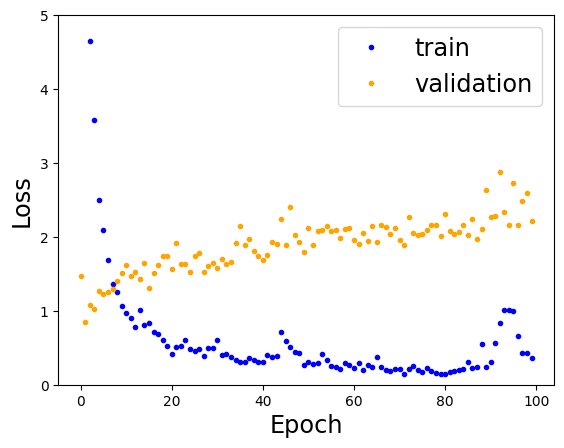

In [ ]:
draw_loss_changes(train_loss, validation_loss)

In [ ]:
eval_model(model, test_loader)

#### Dropout을 사용하지 않는다면 어떻게 될지 살펴보자. 
------

In [ ]:
model = Binary_Classifier_v1(1024, 512, 1, drop_out_rate=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, validation_loss = train_model(model, optimizer, train_loader, val_loader, loss_module)

  2%|▏         | 2/100 [00:00<00:15,  6.39it/s]

Epoch: 000, Training Loss: 19.4196, Validation Loss: 1.3713


  7%|▋         | 7/100 [00:01<00:14,  6.49it/s]

Epoch: 005, Training Loss: 1.2372, Validation Loss: 0.9389


 12%|█▏        | 12/100 [00:01<00:13,  6.45it/s]

Epoch: 010, Training Loss: 0.7261, Validation Loss: 1.0904


 17%|█▋        | 17/100 [00:02<00:12,  6.42it/s]

Epoch: 015, Training Loss: 0.3443, Validation Loss: 1.3263


 22%|██▏       | 22/100 [00:03<00:12,  6.45it/s]

Epoch: 020, Training Loss: 0.2338, Validation Loss: 1.3220


 27%|██▋       | 27/100 [00:04<00:11,  6.43it/s]

Epoch: 025, Training Loss: 0.2426, Validation Loss: 1.3336


 32%|███▏      | 32/100 [00:04<00:10,  6.30it/s]

Epoch: 030, Training Loss: 1.2732, Validation Loss: 1.9487


 37%|███▋      | 37/100 [00:05<00:10,  6.24it/s]

Epoch: 035, Training Loss: 0.2934, Validation Loss: 1.4446


 42%|████▏     | 42/100 [00:06<00:09,  6.32it/s]

Epoch: 040, Training Loss: 0.1846, Validation Loss: 1.5308


 47%|████▋     | 47/100 [00:07<00:08,  6.52it/s]

Epoch: 045, Training Loss: 0.1797, Validation Loss: 1.5707


 52%|█████▏    | 52/100 [00:08<00:07,  6.53it/s]

Epoch: 050, Training Loss: 0.1504, Validation Loss: 1.5412


 57%|█████▋    | 57/100 [00:08<00:06,  6.52it/s]

Epoch: 055, Training Loss: 0.1627, Validation Loss: 1.7187


 62%|██████▏   | 62/100 [00:09<00:05,  6.45it/s]

Epoch: 060, Training Loss: 0.1829, Validation Loss: 1.5954


 67%|██████▋   | 67/100 [00:10<00:05,  6.33it/s]

Epoch: 065, Training Loss: 0.1601, Validation Loss: 1.6809


 72%|███████▏  | 72/100 [00:11<00:04,  6.21it/s]

Epoch: 070, Training Loss: 0.1459, Validation Loss: 1.7006


 77%|███████▋  | 77/100 [00:12<00:03,  6.25it/s]

Epoch: 075, Training Loss: 0.1608, Validation Loss: 1.7785


 82%|████████▏ | 82/100 [00:12<00:02,  6.23it/s]

Epoch: 080, Training Loss: 0.1852, Validation Loss: 1.6852


 87%|████████▋ | 87/100 [00:13<00:02,  6.29it/s]

Epoch: 085, Training Loss: 0.1385, Validation Loss: 1.7641


 92%|█████████▏| 92/100 [00:14<00:01,  6.29it/s]

Epoch: 090, Training Loss: 0.1462, Validation Loss: 1.7153


 97%|█████████▋| 97/100 [00:15<00:00,  6.43it/s]

Epoch: 095, Training Loss: 0.1377, Validation Loss: 1.7835


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


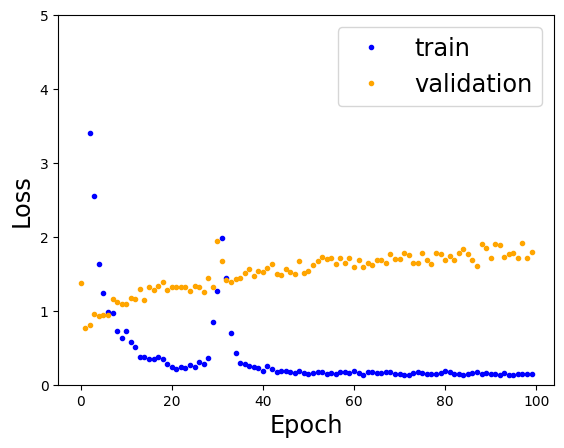

In [ ]:
draw_loss_changes(train_loss, validation_loss)

In [ ]:
eval_model(model, test_loader)

Accuracy of the model: 95.87%


## Activation function
------
일반적으로 Dense layer또는 convolution 연산 이후에는 변수들 사이의 비선형의 관계를 고려하기 위해서 비선형의 활성 함수(activation function)들이 사용된다. 

파이토치에는 [다양한 활성 함수들](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)이 구현되어 있다.

그 중에 많이 사용되는 몇가지만 살펴보겠다. 

### Sigmoid 함수
-------
전통적으로 가장 많이 사용된 activation function은 sigmoid 함수이다. 

$\sigma(x)=1/(1+\exp(-x))$

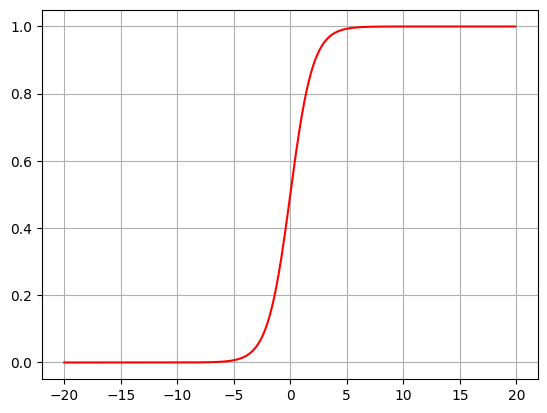

In [ ]:
x=np.arange(-20, 20, 0.1)
y=1.0/(1.0+np.exp(-x))
plt.plot(x,y,'-',color='r')
plt.grid()

sigmoid 함수는 임의의 실수를 (0.0, 1.0) 범위로 mapping 한다. 

예전에는 많이 사용되었으나 deep learning으로 넘어오면서 sigmoid 함수는 기울기 소실 문제(vanishing gradient problem)을 일으킨다는 것이 확인되었다. 

기울기 소실 문제는 층을 여럿 쌓아서 역전파 계산을 수행할 때, 1보다 작은 gradient를 계속 곱해주면 그 값이 0으로 수렴하는 문제를 말한다. 

Sigmoid 함수의 gradient는 0 근방에서는 큰 값을 가지지만 그 외에서는 0에 가까운 값을 가지므로 gradient가 0에 가까워져서 역전파가 일어나지 않는 문제가 있다. 

* sigmoid 함수의 gradient 값을 계산하면 아래와 같다. 

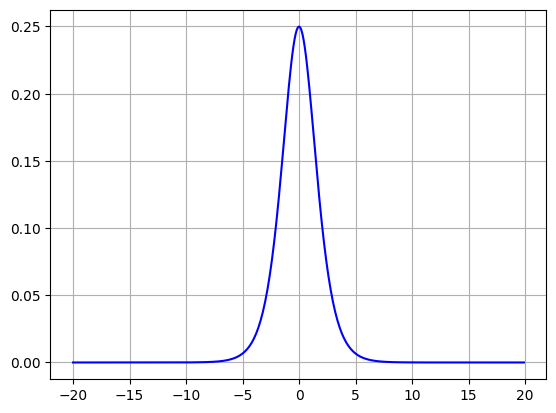

In [ ]:
y2=np.exp(-x)/(1+np.exp(-x))**2
plt.plot(x,y2,'-',color='b')
plt.grid()

### tanh
------
tanh 함수는 sigmoid와 유사한 형태를 가지나 y 값이 -1에서 1까지의 범위를 가진다. 

그러나 sigmoid와 유사한 기울기 소실 문제를 가지고 있다. 

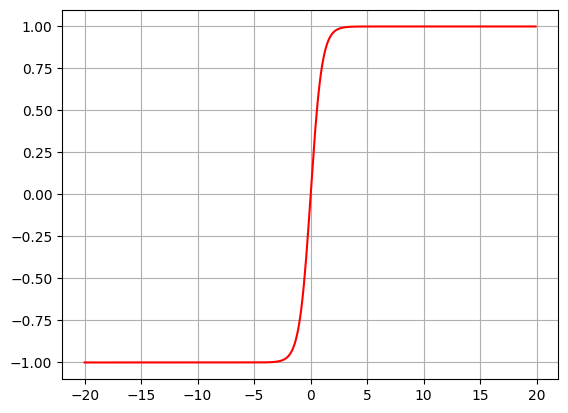

In [ ]:
y2=np.tanh(x)
plt.plot(x,y2,'-',color='r')
plt.grid()

이러한 문제를 해결하기 위해서 다음의 activation function들이 제안되었다. 

### ReLU (Rectified Linear Unit)
-----
위의 기울기 소실 문제를 해결하면서 빠른 계산 속도를 가진 활성 함수는 ReLU이다. 

$\mathrm{ReLU}(x)=\max(0, x)$

https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu



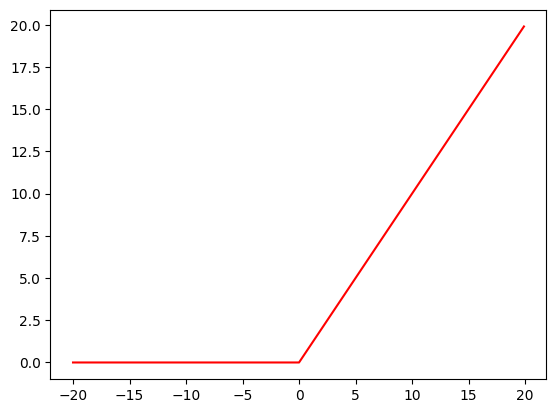

In [ ]:
y=np.maximum(0,x)
plt.plot(x, y, '-', color='red')

### LeakyRELU
------
ReLU의 경우, x 값이 0보다 작을 경우 gradient가 0이 되어 버리므로 종종 기울기 소실 문제에서 자유롭지 못하다. 

이를 해결하기 위해서 x가 음수인 영역에서 gradient를 0으로 만들지 않는 leakyrelu 함수가 제안되었다. 




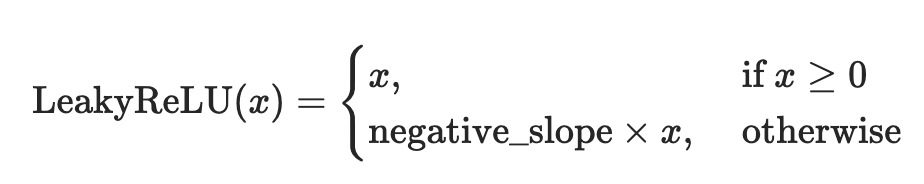

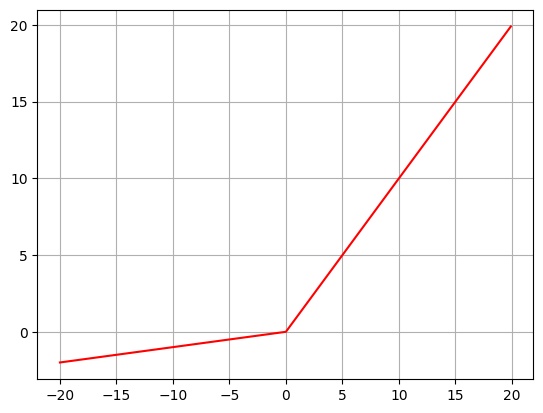

In [ ]:
y=nn.LeakyReLU(0.1)(torch.tensor(x))
plt.plot(x, y, '-', color='red')
plt.grid()

### ELU 
------
ReLU, LeakyRELU 이외에 음수 부분에서 한 값으로 수렴하는 ELU 함수가 제안되었다. 

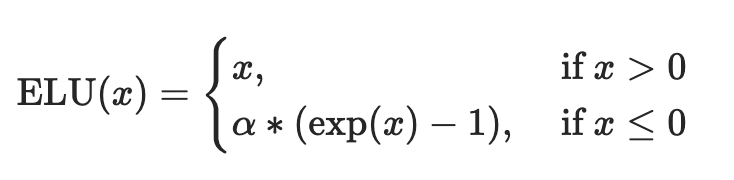

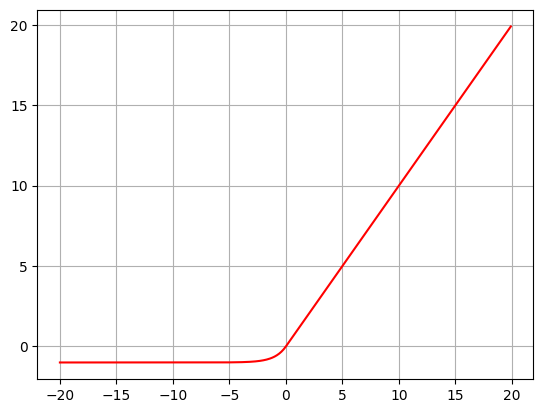

In [ ]:
elu=nn.ELU()
y=elu(torch.tensor(x))
plt.plot(x, y, '-', color='red')
plt.grid()

### Other activation functions
------

이 외에 GELU, SELU, PRELU 등의 함수들이 많이 사용된다. 

실제 모델을 학습시킬 때는 몇 가지 함수들을 테스트 해보고 문제에 가장 좋은 결과를 주는 활성 함수를 택하는 것이 좋다. 

## Optimizer 
------

앞서 이야기 한 것과 같이 deep learning의 학습은 본질적으로 임의의 함수를 매우 많은 개수의 파라미터로 이루어진 linear 함수와 non-linear 함수의 조합으로 근사한 후, loss function을 최소화하는 방향으로 파라미터를 업데이트 시키는 것이라고 할 수 있다. 



가장 단순한 형태는 바로 steepest gradient descent 방법일 것이다. 

이는 주어진 점에서 가장 기울기의 절대값이 큰 방향(가장 가파른 방향)으로 계속 내려가는 방법이다. 

$w^{(t)}_i=w^{(t-1)}_i - \eta \frac{\partial L}{\partial w_i}$

즉, 각 파라미터의 L에 대한 편미분을 계산한 후, 그 기울기의 반대 방향으로 진행하는 것이다. 

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning1.png" width=400>

steepest descent 방법은 구현하기 쉽고 빠르지만 몇 가지 문제점을 가지고 있다. 

<img src="https://trond.hjorteland.com/thesis/img208.gif" width=400>

일반적으로 고차원 공간에서의 최소화 문제를 풀 때, 지그재그 형태로 oscillation을 많이 하기 때문에 매우 느리게 수렴한다. 

그리고 local minima에 빠졌을 때, 더 이상 update되지 않는다. 

<img src="https://www.researchgate.net/publication/334867382/figure/fig3/AS:787290435641344@1564716075015/Depiction-of-the-local-minima-and-global-minimum-in-the-energy-minimization-problem.png" width=400>

<img src="https://skill-lync-portal.nyc3.digitaloceanspaces.com/tinymce/05_20/15900802955804.jpg" width=400>

단순 gradient descent의 경우, 한 번 local minima에 빠지면 다른 minima로 넘어가기 어렵다. 

이러한 문제를 해결하기 위해서 다양한 search method, optimization method들이 제안되었다. 

각 방법들을 모두 설명하는 것은 이번 course의 범위를 넘어서는 것이므로 자세히 다루지는 않겠다. 

<img src="https://velog.velcdn.com/images/freesky/post/ee93674e-5455-4d15-803a-ddab4deac998/image.gif" width=500>

pytorch에서는 다양한 parameter optimizer를 제공하고 있다. 

https://pytorch.org/docs/stable/optim.html

이 중에서 가장 많이 사용되는 것은 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)와 [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) 방법이다.

대부분의 경우, Adam 또는 SGD 방법을 사용하면 좋은 성능을 얻을 수 있다. 

혹시 모델 학습이 잘 되지 않을 경우, 다른 optimizer를 사용해보는 것도 해결 방법이 될 수 있다. 

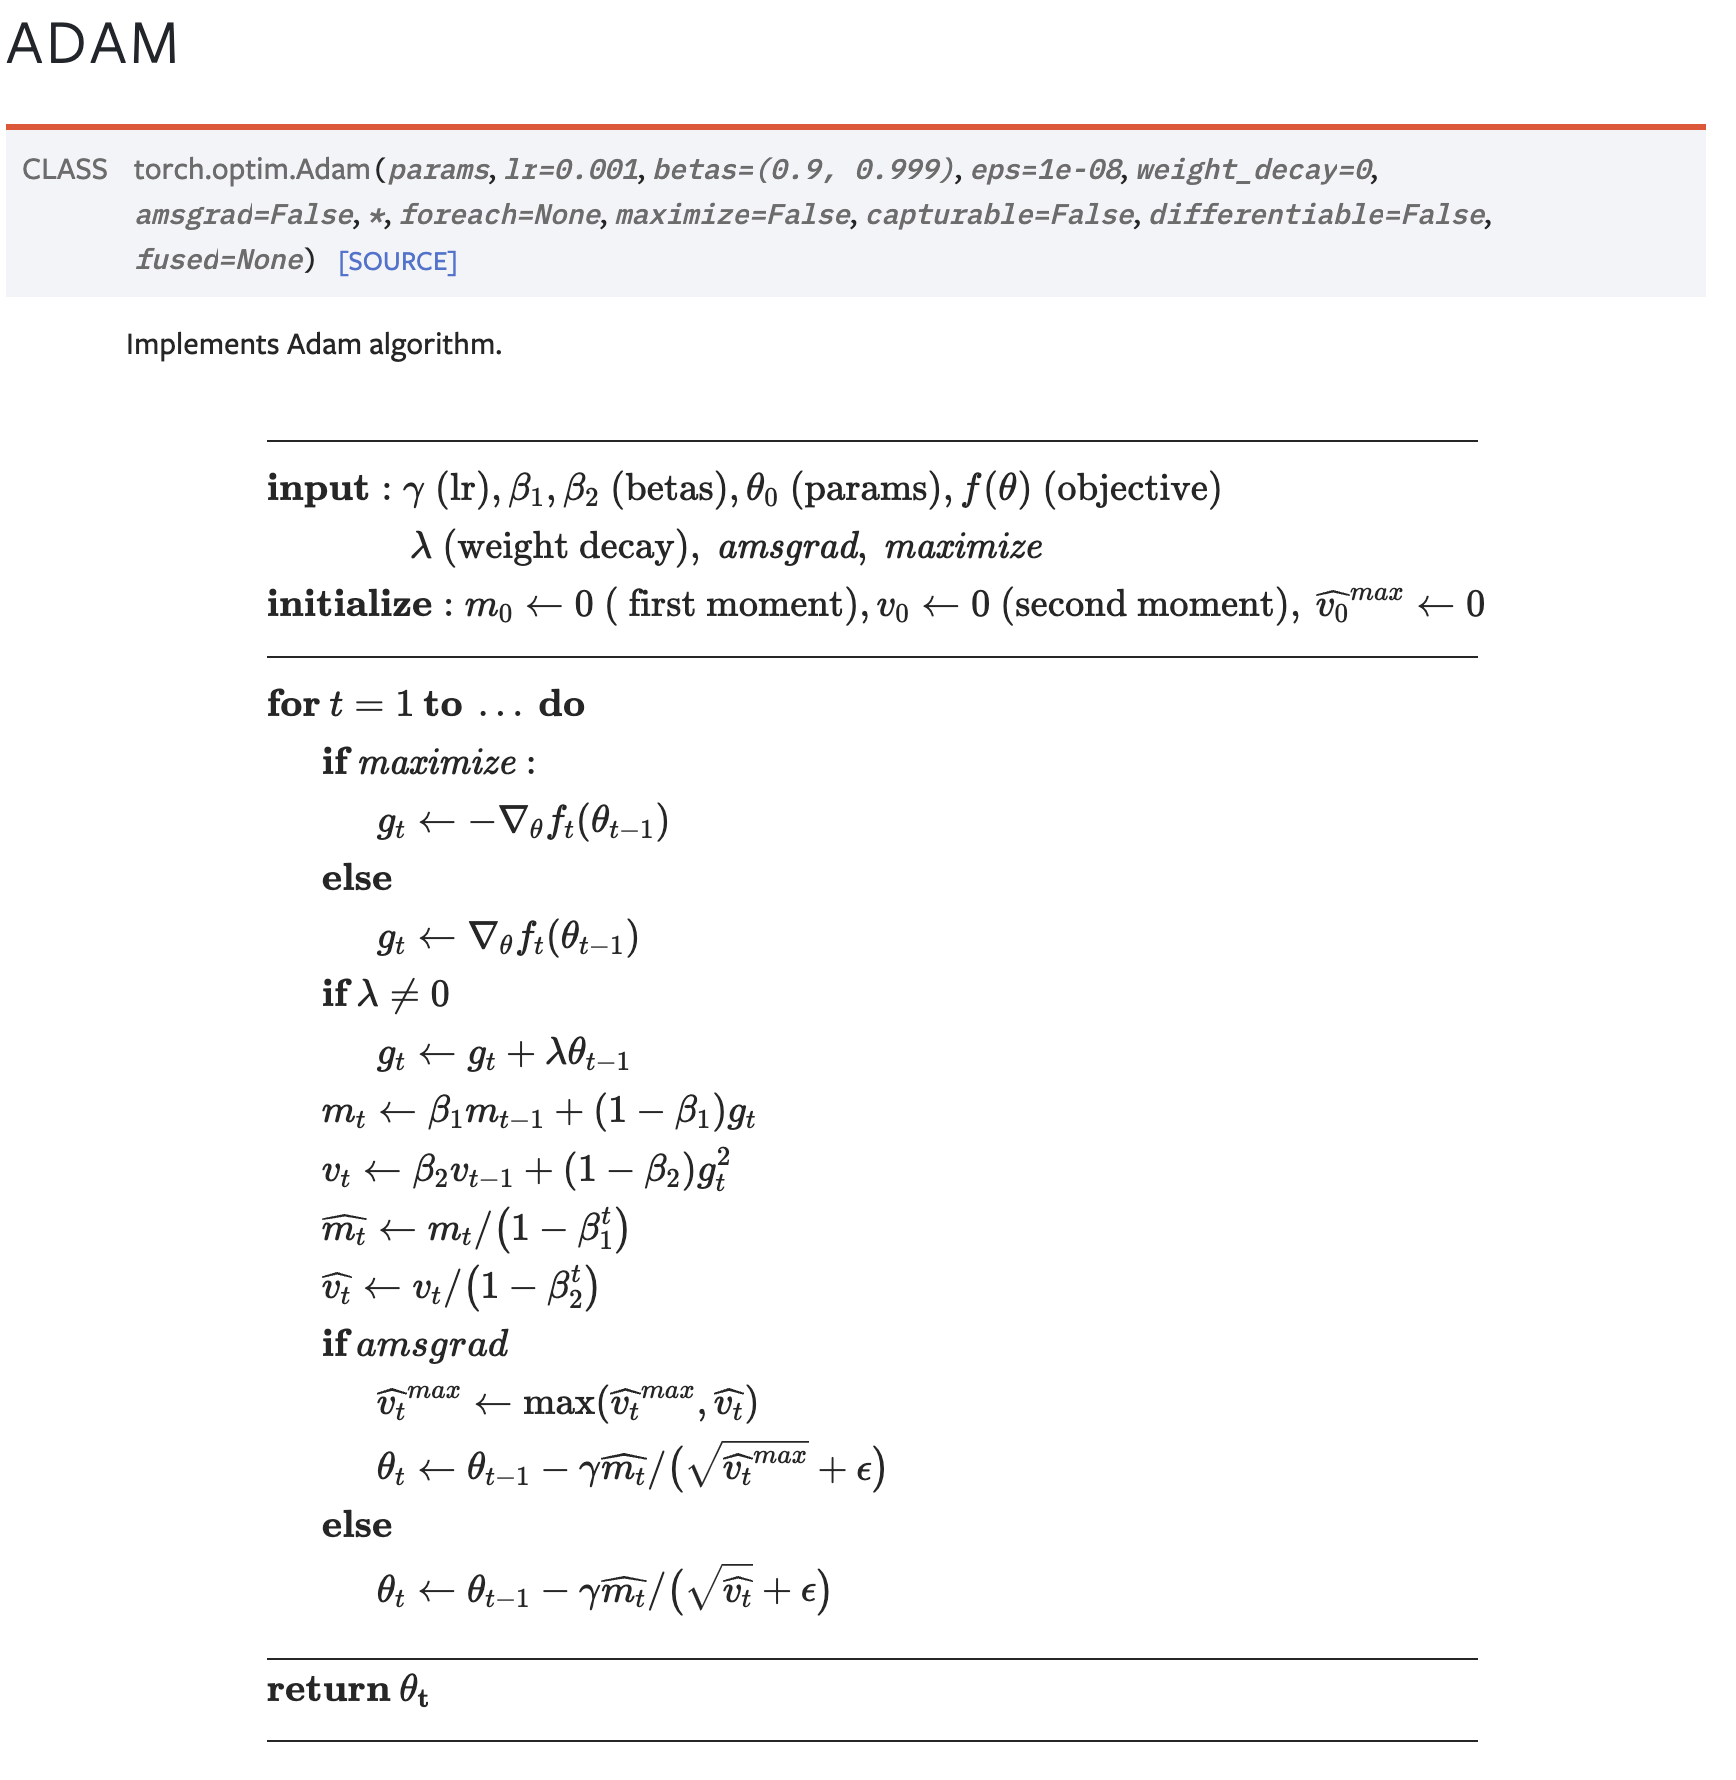

# ResNet (Skip connection)
------

모델의 성능을 향상 시키기 위해서 단순히 차례로 layer들을 통과하는 것이 아니라 다양한 network 구조의 변형들이 제안되었다. 

그 중에서 가장 중요한 skip connection에 대해서 간단히 다루도록 하겠다. 




Skip connection은 다음과 같이 그림으로 표현될 수 있다. 

<img src="https://programmathically.com/wp-content/uploads/2022/01/Screenshot-2022-01-30-at-08.57.06.png" width=600>



<img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/resnet_block.svg" width=600>


위의 그림에서 알 수 있듯이, skip connection은 입력 텐서를 layer를 통과한 출력 텐서와 더해주는 것을 의미한다. 

즉, 식으로 표현하면 다음과 같다. 

$x_\text{l+1} = F(x_\text{l}) + x_\text{l}$

위에서 $x_l$과 $x_{l+1}$은 $l$ 번째 layer를 통과한 후의 텐서에 해당한다. 

이러한 skip connection은 개념적으로는 identify operation을 1st order approximation으로 보는 것이라고 할 수 있다. 

따라서 임의의 layer는 $\mathbf{x_{l+1}} - \mathbf{x_{l}}$에 해당하는 잔차를 예측하게 된다. 

이러한 [Residual connection](https://arxiv.org/abs/1512.03385)은 실제 딥러닝 모델에 있어서 많은 응용에 상당히 많은 성능 향상을 가져왔다. 왜 Skip connection이 좋은 성능을 내는 지에 대해서는 이론적으로 완전히 이해가 되고 있지는 않지만 일반적으로 parameter space의 모양을 덜 울퉁불퉁하게 (less rugged) 만든다고 추측되고 있다. 

<img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/resnet_loss_surface.svg" width=600>

ref: https://arxiv.org/pdf/1712.09913.pdf





## Implementation of Skip Connection

이제 ResNet을 위의 모델에 적용해보자. 

In [ ]:
class Binary_Classifier_v2_with_skip(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, drop_out_rate=0.1):
        super().__init__()
        # 네트워크를 구성하는 위한 기반이 되는 layer들을 정의한다. 
        # 차원의 변화: num_inputs  -> num_hidden
        self.linear1 = nn.Linear(num_inputs, num_hidden) 
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        self.linear3 = nn.Linear(num_hidden, num_outputs)
 
        # activation function
        self.act_fn = nn.ReLU()

        # dropout layer: 30%의 node의 output을 사용하지 않음. 
        self.dropout = nn.Dropout(drop_out_rate)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x0 = x
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.act_fn(x) + x0 # Add identity vector
        
        x0 = x
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.bn2(x)
        x = self.act_fn(x) + x0 # Add identity vector
        
        x = self.linear3(x) 

        return x

위의 모델에서 주의할 점은 입력 텐서와 변화된 후의 텐서의 차원 수가 맞아야 모델 학습이 제대로 진행이 된다. 

그러므로 일단 입력과 숨겨진 차원이 모두 1024인 모델을 아래와 같이 정의하고 학습을 진행해보자. 

In [ ]:
model = Binary_Classifier_v2_with_skip(1024, 1024, 1, drop_out_rate=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, validation_loss = train_model(model, optimizer, train_loader, val_loader, loss_module)

  2%|▏         | 2/100 [00:00<00:15,  6.13it/s]

Epoch: 000, Training Loss: 8.1385, Validation Loss: 0.6482


  7%|▋         | 7/100 [00:01<00:15,  6.06it/s]

Epoch: 005, Training Loss: 0.7405, Validation Loss: 1.0897


 12%|█▏        | 12/100 [00:01<00:14,  6.03it/s]

Epoch: 010, Training Loss: 0.3396, Validation Loss: 1.1747


 17%|█▋        | 17/100 [00:02<00:13,  5.96it/s]

Epoch: 015, Training Loss: 0.3494, Validation Loss: 1.2464


 22%|██▏       | 22/100 [00:03<00:13,  5.86it/s]

Epoch: 020, Training Loss: 0.2199, Validation Loss: 1.2606


 27%|██▋       | 27/100 [00:04<00:12,  5.94it/s]

Epoch: 025, Training Loss: 0.2763, Validation Loss: 1.4084


 32%|███▏      | 32/100 [00:05<00:11,  6.10it/s]

Epoch: 030, Training Loss: 0.2312, Validation Loss: 1.4505


 37%|███▋      | 37/100 [00:06<00:10,  6.19it/s]

Epoch: 035, Training Loss: 0.1738, Validation Loss: 1.5466


 42%|████▏     | 42/100 [00:06<00:09,  6.12it/s]

Epoch: 040, Training Loss: 1.4492, Validation Loss: 1.5165


 47%|████▋     | 47/100 [00:07<00:08,  6.15it/s]

Epoch: 045, Training Loss: 0.2204, Validation Loss: 1.6689


 52%|█████▏    | 52/100 [00:08<00:08,  5.83it/s]

Epoch: 050, Training Loss: 0.1783, Validation Loss: 1.7995


 57%|█████▋    | 57/100 [00:09<00:07,  5.62it/s]

Epoch: 055, Training Loss: 0.1720, Validation Loss: 1.8340


 62%|██████▏   | 62/100 [00:10<00:06,  5.82it/s]

Epoch: 060, Training Loss: 0.1285, Validation Loss: 1.8576


 67%|██████▋   | 67/100 [00:11<00:05,  5.80it/s]

Epoch: 065, Training Loss: 0.1649, Validation Loss: 1.8304


 72%|███████▏  | 72/100 [00:12<00:05,  5.58it/s]

Epoch: 070, Training Loss: 0.2156, Validation Loss: 1.8246


 77%|███████▋  | 77/100 [00:12<00:03,  5.79it/s]

Epoch: 075, Training Loss: 0.1866, Validation Loss: 1.8371


 82%|████████▏ | 82/100 [00:13<00:03,  5.89it/s]

Epoch: 080, Training Loss: 0.4867, Validation Loss: 2.3440


 87%|████████▋ | 87/100 [00:14<00:02,  5.56it/s]

Epoch: 085, Training Loss: 0.1802, Validation Loss: 2.0386


 92%|█████████▏| 92/100 [00:15<00:01,  5.78it/s]

Epoch: 090, Training Loss: 0.1893, Validation Loss: 2.0586


 97%|█████████▋| 97/100 [00:16<00:00,  5.98it/s]

Epoch: 095, Training Loss: 0.1654, Validation Loss: 2.1396


100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


In [ ]:
eval_model(model, test_loader)

Accuracy of the model: 96.29%


### Skip connection with dimesion changes
------
input dimension과 hidden dimension이 다를 경우에는 차원을 맞추어 주기 위해서 Linear layer를 이용해서 shortcut을 정의할 수 있다. 

이는 Identity operation은 아님을 주의히자. 

In [ ]:
class Binary_Classifier_v3_with_skip(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, drop_out_rate=0.1):
        super().__init__()
        # 네트워크를 구성하는 위한 기반이 되는 layer들을 정의한다. 
        # 차원의 변화: num_inputs  -> num_hidden
        self.linear1 = nn.Linear(num_inputs, num_hidden) 
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        self.linear3 = nn.Linear(num_hidden, num_outputs)
        
        self.shortcut1 = nn.Linear(num_inputs, num_hidden)
        self.shortcut2 = nn.Linear(num_hidden, num_hidden)

        # activation function
        self.act_fn = nn.ReLU()

        # dropout layer: 30%의 node의 output을 사용하지 않음. 
        self.dropout = nn.Dropout(drop_out_rate)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x0 = x
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.act_fn(x) + self.shortcut1(x0)
        
        x0 = x
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.bn2(x)
        x = self.act_fn(x) + self.shortcut2(x0)

        #x = self.act_fn(x)
        x = self.linear3(x) 

        return x

In [ ]:
model = Binary_Classifier_v3_with_skip(1024, 256, 1, drop_out_rate=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, validation_loss = train_model(model, optimizer, train_loader, val_loader, loss_module, num_epochs=100)

  2%|▏         | 2/100 [00:00<00:17,  5.57it/s]

Epoch: 000, Training Loss: 7.2379, Validation Loss: 0.6742


  7%|▋         | 7/100 [00:01<00:17,  5.36it/s]

Epoch: 005, Training Loss: 0.9610, Validation Loss: 1.2877


 12%|█▏        | 12/100 [00:02<00:16,  5.47it/s]

Epoch: 010, Training Loss: 0.4906, Validation Loss: 1.6506


 17%|█▋        | 17/100 [00:03<00:15,  5.43it/s]

Epoch: 015, Training Loss: 0.4078, Validation Loss: 1.6976


 22%|██▏       | 22/100 [00:04<00:14,  5.47it/s]

Epoch: 020, Training Loss: 0.3232, Validation Loss: 1.4210


 27%|██▋       | 27/100 [00:04<00:13,  5.46it/s]

Epoch: 025, Training Loss: 0.3160, Validation Loss: 1.6078


 32%|███▏      | 32/100 [00:05<00:12,  5.53it/s]

Epoch: 030, Training Loss: 0.2257, Validation Loss: 1.6089


 37%|███▋      | 37/100 [00:06<00:11,  5.49it/s]

Epoch: 035, Training Loss: 0.2917, Validation Loss: 1.7800


 42%|████▏     | 42/100 [00:07<00:10,  5.53it/s]

Epoch: 040, Training Loss: 0.5274, Validation Loss: 1.6913


 47%|████▋     | 47/100 [00:08<00:09,  5.54it/s]

Epoch: 045, Training Loss: 0.2523, Validation Loss: 1.9641


 52%|█████▏    | 52/100 [00:09<00:08,  5.43it/s]

Epoch: 050, Training Loss: 0.2012, Validation Loss: 1.7853


 57%|█████▋    | 57/100 [00:10<00:07,  5.40it/s]

Epoch: 055, Training Loss: 0.2346, Validation Loss: 1.7840


 62%|██████▏   | 62/100 [00:11<00:07,  5.32it/s]

Epoch: 060, Training Loss: 0.1867, Validation Loss: 1.7284


 67%|██████▋   | 67/100 [00:12<00:06,  5.42it/s]

Epoch: 065, Training Loss: 0.1882, Validation Loss: 1.7142


 72%|███████▏  | 72/100 [00:13<00:05,  5.39it/s]

Epoch: 070, Training Loss: 0.1820, Validation Loss: 1.8067


 77%|███████▋  | 77/100 [00:14<00:04,  5.34it/s]

Epoch: 075, Training Loss: 0.2962, Validation Loss: 1.8959


 82%|████████▏ | 82/100 [00:15<00:03,  5.38it/s]

Epoch: 080, Training Loss: 0.5338, Validation Loss: 2.3803


 87%|████████▋ | 87/100 [00:16<00:02,  5.29it/s]

Epoch: 085, Training Loss: 0.1934, Validation Loss: 2.1559


 92%|█████████▏| 92/100 [00:16<00:01,  5.31it/s]

Epoch: 090, Training Loss: 0.2296, Validation Loss: 1.9967


 97%|█████████▋| 97/100 [00:17<00:00,  5.46it/s]

Epoch: 095, Training Loss: 0.2618, Validation Loss: 1.7697


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


In [ ]:
eval_model(model, test_loader)

Accuracy of the model: 95.87%


## 숙제 1: 위의 모델 들의 네트워크 구조, hidden dimesion, optimizer 등을 바꾸어 가면서 test set에 대해서 accuracy 값이 97% 이상이 나오는 network을 훈련시켜 보라. 

## 숙제 2: Blood-Brain barrier 통과 여부를 예측하는 모델 학습
------
뇌세포와 뇌혈관 사이에는 외부 물질이 뇌로 들어가는 것을 막는 뇌혈관 장벽(Blood-brain barrier, CNS)가 존재한다. 이 BBB 통과 여부가 central nerve system(CNS)에 작용하는 약물 개발에 매우 중요하다. 최근 2021년, 중앙대 나도균 교수 연구실에서는 분자의 BBB 통과 여부를 예측하는 [LightBBB](https://academic.oup.com/bioinformatics/article/37/8/1135/5942084)라는 모델을 개발하여 공개하였다. 통과 여부를 예측하는 binary classification model의 경우 **accuracy 89%, AUC값 0.93**을 달성하였다. 

여러분도 직접 동일한 데이터를 받아서 비슷한 정도의 정확도를 달성할 수 있을지 확인해보세요. 

http://bioanalysis.cau.ac.kr:7030/
데이터셋: http://ssbio.cau.ac.kr/public/LightBBB_dataset.zip

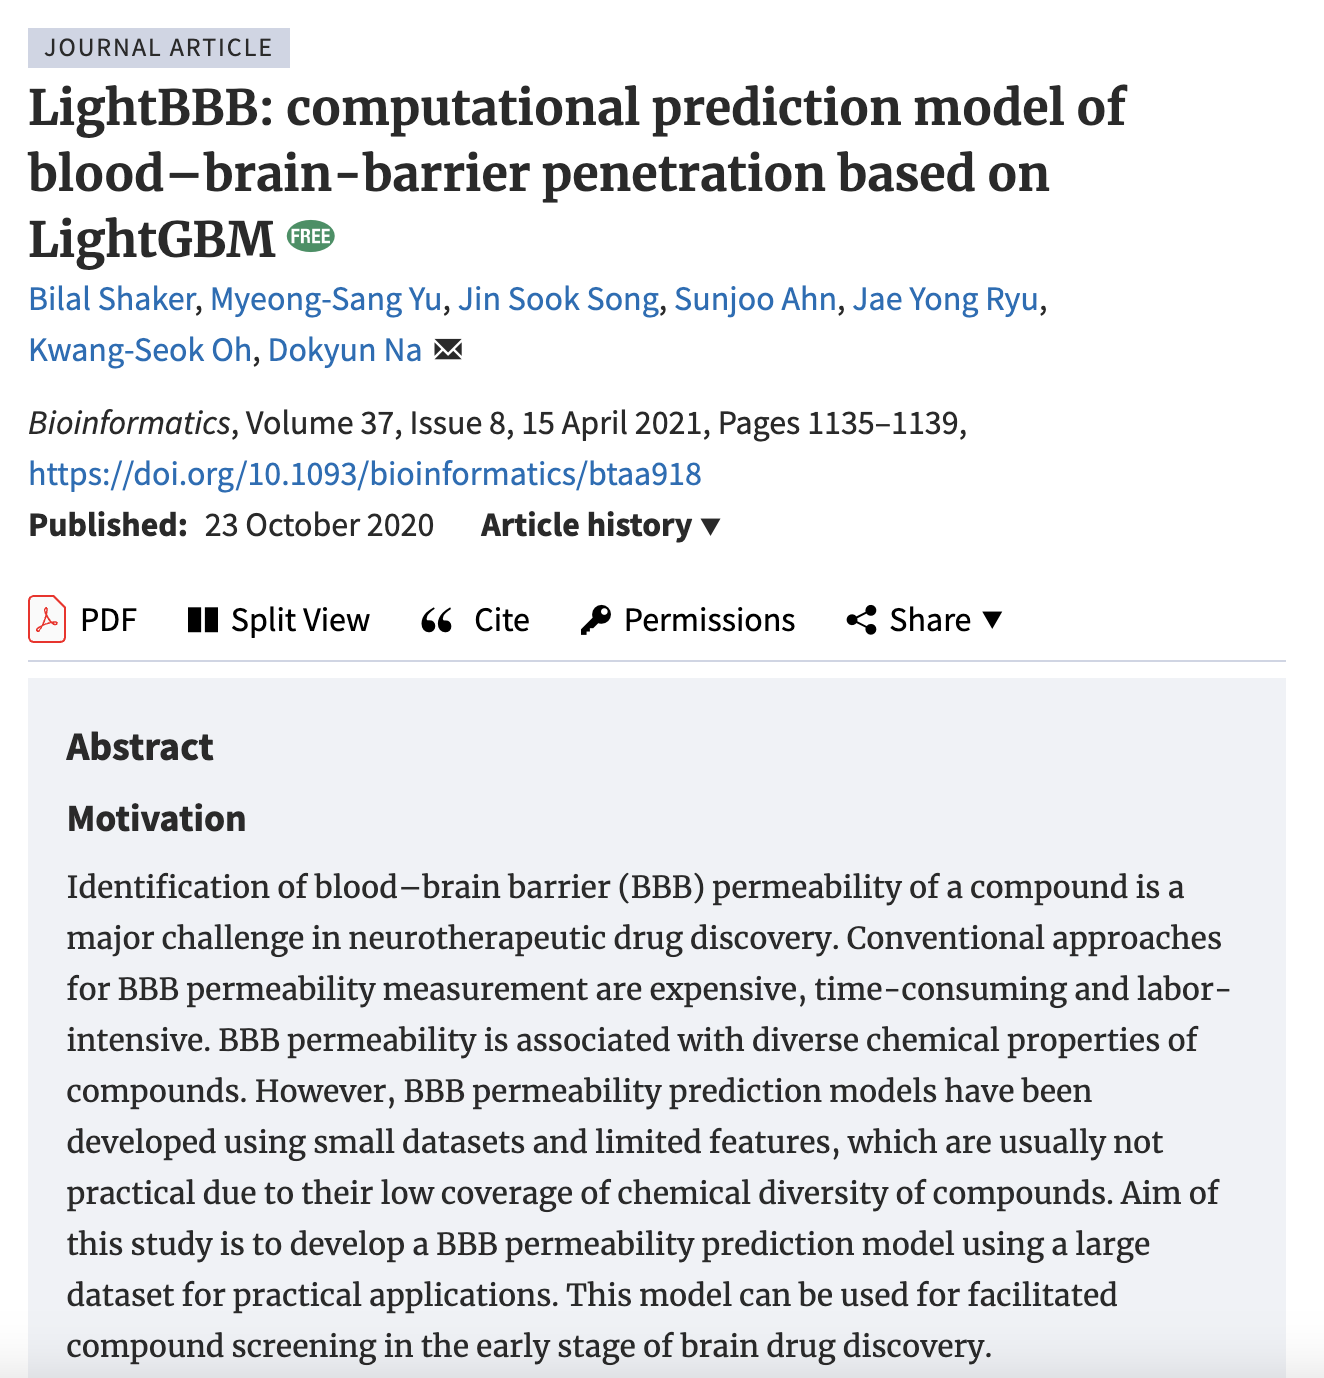